# Cart-Pole Game. Deep Q-Learning.

In [1]:
# Import libraries.
import random
from collections import deque
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Create the cart-pole environment.
env = gym.make("CartPole-v0")

In [4]:
# Build the network.
input_size = env.observation_space.shape[0]

input_placeholder = tf.placeholder("float", [None, input_size])

# Weights and bias of the hidden layer.
weights_1 = tf.Variable(tf.truncated_normal([input_size, 20], stddev = 0.01))
bias_1 = tf.Variable(tf.constant(0.0, shape = [20]))

# Weights and bias of the output layer.
weights_2 = tf.Variable(tf.truncated_normal([20, env.action_space.n], stddev = 0.01))
bias_2 = tf.Variable(tf.constant(0.0, shape = [env.action_space.n]))

hidden_layer = tf.nn.tanh(tf.matmul(input_placeholder, weights_1) + bias_1)
output_layer = tf.matmul(hidden_layer, weights_2) + bias_2

action_placeholder = tf.placeholder("float", [None, 2])
target_placeholder = tf.placeholder("float", [None])

In [5]:
# Network estimation.
q_estimation = tf.reduce_sum(tf.multiply(output_layer, action_placeholder), reduction_indices = 1)

# Loss function.
loss = tf.reduce_mean(tf.square(target_placeholder - q_estimation))

# Use Adam.
train_operation = tf.train.AdamOptimizer().minimize(loss)

# Initialize TF variable.
session = tf.Session()
session.run(tf.global_variables_initializer())

In [6]:
def choose_next_action(state, rand_action_prob):
    """
    Simplified e-greedy policy.
    :param state: current state
    :param rand_action_prob: probability to select random action 
    """
    new_action = np.zeros([env.action_space.n])
    if random.random() <= rand_action_prob: 
        # Choose an action randomly.
        action_index = random.randrange(env.action_space.n)
    else: 
        # Choose an action given our state.
        action_values = session.run(output_layer, feed_dict = {input_placeholder: [state]})[0]

        # We will take the highest value action.
        action_index = np.argmax(action_values)
        
    new_action[action_index] = 1
    return new_action

In [7]:
def train(mini_batch):
    """
    Train the network on a single minibatch
    :param mini_batch the mini-batch
    """
    last_state, last_action, reward, current_state, terminal = range(5)
    
    # Get the batch variables.
    previous_states = [d[last_state] for d in mini_batch]
    actions = [d[last_action] for d in mini_batch]
    rewards = [d[reward] for d in mini_batch]
    current_states = [d[current_state] for d in mini_batch]
    agents_expected_reward = []
    
    # This gives us the agents expected reward for each action we might take.
    agents_reward_per_action = session.run(output_layer, feed_dict = {input_placeholder: current_states})
    for i in range(len(mini_batch)):
        if mini_batch[i][terminal]:
            # This was a terminal frame so there is no future reward...
            agents_expected_reward.append(rewards[i])
        else: 
            # Otherwise compute expected reward.
            discount_factor = 0.9
            agents_expected_reward.append(rewards[i] + discount_factor * np.max(agents_reward_per_action[i]))
            
    # Learn that these actions in these states lead to this reward.
    session.run(train_operation, feed_dict = {
        input_placeholder: previous_states, 
        action_placeholder: actions, 
        target_placeholder: agents_expected_reward
    })

In [8]:
def q_learning(): 
    """The Q-learning method"""
    episode_lengths = list()
    
    # Experience replay buffer and definition.
    observations = deque(maxlen = 200000)
    
    # Set the first action to nothing.
    last_action = np.zeros(env.action_space.n)
    last_action[1] = 1
    last_state = env.reset()
    
    total_reward = 0
    episode = 1
    
    time_step = 0
    
    # Initial chance to select random action.
    rand_action_prob = 1.0
    
    while episode <= 500: 
        # Render the cart pole on the screen.
        
        if episode >= 300:
            env.render()
        
        # Select action following the policy.
        last_action = choose_next_action(last_state, rand_action_prob)
        
        # Take action and receive new state and reward.
        current_state, reward, terminal, info = env.step(np.argmax(last_action))
        total_reward += reward
        
        if terminal: 
            reward = -1
            episode_lengths.append(time_step)
            
            #print("Episode: %s; Steps before fail: %s; Epsilon: %.2f reward %s" % (episode, time_step, rand_action_prob, total_reward))
            total_reward = 0
            
        # Store the transition in previous observations.
        observations.append((last_state, last_action, reward, current_state, terminal))
        
        # Only train if done observing.
        min_experience_replay_size = 5000
        if len(observations) > min_experience_replay_size: 
            # Mini batch of 128 from the experience replay observations.
            mini_batch = random.sample(observations, 128)
            
            # Train the network.
            train(mini_batch)
            
            time_step += 1
        
        # Reset the environment.
        if terminal: 
            last_state = env.reset()
            time_step = 0
            episode += 1
        else: 
            last_state = current_state
            
        # Gradually reduce the probability of a random action
        # Starting from 1 and going to 0
        if rand_action_prob > 0  and len(observations) > min_experience_replay_size: 
            rand_action_prob -= 1.0 / 15000
            
    # Display episodes length.
    plt.xlabel("Episode")
    plt.ylabel("Length (steps)")
    plt.plot(episode_lengths, label = "Episode length")
    plt.show()

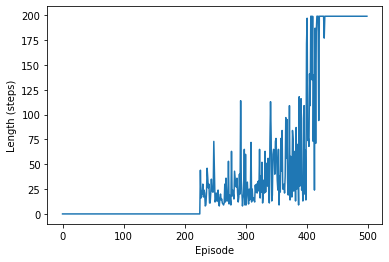

In [16]:
q_learning()